In [44]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [45]:
# Define directories for training and test data
train_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Train_Data"
test_dir = r"C:\Users\ganga\Documents\IISc Coursework\ML4CPS\Project1\Project 1 Data\Project 1 Data\Test_Data"

In [46]:
# Step 2: Load and Preprocess Training Data
IMG_SIZ = (224, 224)
#IMG_SIZE = (400, 300)
ALLOWED_EXTENSIONS = {'.jpg', '.jpeg', '.png'}

In [47]:
# Function to load training data
def load_data(train_dir):
    images = []
    labels = []
    label_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'S': 5}

    for folder in os.listdir(train_dir):
        folder_path = os.path.join(train_dir, folder)
        if os.path.isdir(folder_path) and folder in label_map:
            for img_name in os.listdir(folder_path):
                if not any(img_name.lower().endswith(ext) for ext in ALLOWED_EXTENSIONS):
                    continue
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, IMG_SIZ)
                    images.append(img)
                    labels.append(label_map[folder])
    return np.array(images), np.array(labels)


In [48]:
if os.path.exists(train_dir):
    images, labels = load_data(train_dir)
    print(f"Loaded {len(images)} images.")
    print(f"Shape of images array: {images.shape}")
    print(f"Shape of labels array: {labels.shape}")

Loaded 2516 images.
Shape of images array: (2516, 224, 224, 3)
Shape of labels array: (2516,)


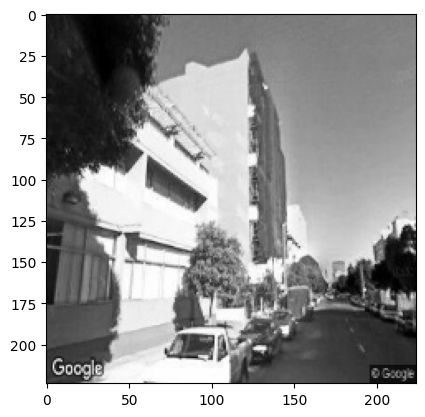

Image shape: (224, 224, 3)
Label: 1


In [49]:
plt.imshow(images[2])
plt.show()
print(f"Image shape: {images[0].shape}")
#Show label on the image
print(f"Label: {labels[3]}")

In [50]:
# Step 3: Prepare Data for Training
labels = labels - 1  # Adjust labels to be 0-based

In [51]:
#Check if any data is missing in images or labels
print(f"Number of missing images: {np.sum([img is None for img in images])}")
print(f"Number of missing labels: {np.sum([label is None for label in labels])}")


Number of missing images: 0
Number of missing labels: 0


In [52]:
# Advanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,  # Reduce rotation range
    width_shift_range=0.1,  # Reduce shift range
    height_shift_range=0.1,  # Reduce shift range
    shear_range=0.1,  # Reduce shear range
    zoom_range=0.1,  # Reduce zoom
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [54]:
"""minority_class_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_minority_class = minority_class_augmentation.flow(X_train_minority_class, y_train_minority_class, batch_size=32)"""

"minority_class_augmentation = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=40,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n)\n\naugmented_minority_class = minority_class_augmentation.flow(X_train_minority_class, y_train_minority_class, batch_size=32)"

In [55]:
"""#Apply data augmentation to minnority classes A, B, S
X_train_augmented = []
y_train_augmented = []

for i in range(5):
    X_train_class = X_train[y_train == i]
    y_train_class = y_train[y_train == i]
    if i in [0, 1, 4]:
        for X_batch, y_batch in datagen.flow(X_train_class, y_train_class, batch_size=32):
            X_train_augmented.append(X_batch)
            y_train_augmented.append(y_batch)
            if len(X_train_augmented) >= 100:
                break
    else:
        X_train_augmented.append(X_train_class)
        y_train_augmented.append(y_train_class)
        
X_train = np.concatenate([X_train, *X_train_augmented])
y_train = np.concatenate([y_train, *y_train_augmented])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")"""

'#Apply data augmentation to minnority classes A, B, S\nX_train_augmented = []\ny_train_augmented = []\n\nfor i in range(5):\n    X_train_class = X_train[y_train == i]\n    y_train_class = y_train[y_train == i]\n    if i in [0, 1, 4]:\n        for X_batch, y_batch in datagen.flow(X_train_class, y_train_class, batch_size=32):\n            X_train_augmented.append(X_batch)\n            y_train_augmented.append(y_batch)\n            if len(X_train_augmented) >= 100:\n                break\n    else:\n        X_train_augmented.append(X_train_class)\n        y_train_augmented.append(y_train_class)\n        \nX_train = np.concatenate([X_train, *X_train_augmented])\ny_train = np.concatenate([y_train, *y_train_augmented])\nprint(f"Shape of X_train: {X_train.shape}")\nprint(f"Shape of y_train: {y_train.shape}")'

In [56]:
#Code to find number of images in each class
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))


{0: 241, 1: 286, 2: 585, 3: 727, 4: 173}

In [57]:
# Define the augmentation strategy
datagen_augment = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images for selected classes
def augment_class_images(X_train, y_train, target_classes, n_augmented_images=200):
    augmented_X = []
    augmented_y = []
    
    for target_class in target_classes:
        # Filter images belonging to the current target class
        class_indices = np.where(y_train == target_class)[0]
        X_class = X_train[class_indices]
        
        # Generate augmented images for the target class
        i = 0
        for X_batch in datagen_augment.flow(X_class, batch_size=1, seed=42):
            augmented_X.append(X_batch[0])
            augmented_y.append(target_class)
            i += 1
            if i >= n_augmented_images:
                break  # Stop once we have generated enough images for the class
    
    # Convert to numpy arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    
    # Concatenate the original and augmented datasets
    X_train_augmented = np.concatenate([X_train, augmented_X], axis=0)
    y_train_augmented = np.concatenate([y_train, augmented_y], axis=0)
    
    return X_train_augmented, y_train_augmented

# Assuming X_train and y_train are your training data and labels
# Classes to augment: 0, 1, and 4
target_classes = [0, 1, 4]

# Perform augmentation and get the updated training set
X_train, y_train = augment_class_images(X_train, y_train, target_classes, n_augmented_images=100)

# Now, you can use X_train_augmented and y_train_augmented for model training


In [58]:
"""#Add augmented data to training set 
augmented_images = []
augmented_labels = []
for X_batch, y_batch in datagen.flow(images, labels, batch_size=len(images)):
    augmented_images.append(X_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) * len(X_batch) >= 5000:
        break
augmented_images = np.concatenate(augmented_images)
augmented_labels = np.concatenate(augmented_labels)
X_train = np.concatenate([X_train, augmented_images])
y_train = np.concatenate([y_train, augmented_labels])
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")"""

'#Add augmented data to training set \naugmented_images = []\naugmented_labels = []\nfor X_batch, y_batch in datagen.flow(images, labels, batch_size=len(images)):\n    augmented_images.append(X_batch)\n    augmented_labels.append(y_batch)\n    if len(augmented_images) * len(X_batch) >= 5000:\n        break\naugmented_images = np.concatenate(augmented_images)\naugmented_labels = np.concatenate(augmented_labels)\nX_train = np.concatenate([X_train, augmented_images])\ny_train = np.concatenate([y_train, augmented_labels])\nprint(f"Shape of X_train: {X_train.shape}")\nprint(f"Shape of y_train: {y_train.shape}")'

In [59]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=5)
y_val = to_categorical(y_val, num_classes=5)

#Edge detection on all the images in the dataset
def edge_detection(img):
    # Conver    t image to grayscale if it is not already
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 250, 300)
    return edges    

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Edge detection on all the images in the dataset
def edge_detection(img):
    # Convert image to grayscale if it is not already
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Ensure the image is of type uint8
    img = img.astype(np.uint8)
    edges = cv2.Canny(img, 250, 300)
    return edges    

# Assuming X_train is defined and contains the training images
# Apply edge detection to all images
images_edges = np.array([edge_detection(img) for img in X_train])

# Display an edge-detected image
plt.imshow(images_edges[6], cmap='gray')
plt.title('Edge Detection')
plt.show()

In [60]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [61]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

In [62]:

# Load the ResNet50 model without the top layer (classifier)
resnet_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [63]:
#Freeze the base model
resnet_model.trainable = False  

In [64]:
#Code to define focal loss for class
""""
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed
    """

"""def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = -alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)
        return K.mean(fl)
    return focal_loss_fixed
    """

'def focal_loss(gamma=2., alpha=0.25):\n    def focal_loss_fixed(y_true, y_pred):\n        epsilon = K.epsilon()\n        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)\n        y_true = tf.convert_to_tensor(y_true, tf.float32)\n        alpha_t = y_true * alpha + (K.ones_like(y_true) - y_true) * (1 - alpha)\n        p_t = y_true * y_pred + (K.ones_like(y_true) - y_true) * (1 - y_pred)\n        fl = -alpha_t * K.pow((K.ones_like(y_true) - p_t), gamma) * K.log(p_t)\n        return K.mean(fl)\n    return focal_loss_fixed\n    '

In [66]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [67]:
#REDUCE LR ON PLATEAU
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [68]:
import tensorflow as tf
from tensorflow.keras import backend as K


In [69]:
from sklearn.utils import resample

# Separate the classes
class_0 = X_train[y_train[:, 0] == 1]
class_1 = X_train[y_train[:, 1] == 1]
class_2 = X_train[y_train[:, 2] == 1]
class_3 = X_train[y_train[:, 3] == 1]
class_4 = X_train[y_train[:, 4] == 1]

# Oversample classes 0, 1, 4
class_0_oversampled = resample(class_0, replace=True, n_samples=400, random_state=42)
class_1_oversampled = resample(class_1, replace=True, n_samples=400, random_state=42)
class_4_oversampled = resample(class_4, replace=True, n_samples=300, random_state=42)

# Undersample classes 2, 3
class_2_undersampled = resample(class_2, replace=False, n_samples=400, random_state=42)
class_3_undersampled = resample(class_3, replace=False, n_samples=400, random_state=42)

# Combine the resampled classes
X_train_resampled = np.concatenate([class_0_oversampled, class_1_oversampled, class_2_undersampled, class_3_undersampled, class_4_oversampled])
y_train_resampled = np.concatenate([
    np.tile([1, 0, 0, 0, 0], (400, 1)),
    np.tile([0, 1, 0, 0, 0], (400, 1)),
    np.tile([0, 0, 1, 0, 0], (400, 1)),
    np.tile([0, 0, 0, 1, 0], (400, 1)),
    np.tile([0, 0, 0, 0, 1], (300, 1))
])




In [70]:
# Sum the one-hot encoded labels along the rows to get the count of each class
class_counts = np.sum(y_train_resampled, axis=0)
print("Number of images in each class:", class_counts)


Number of images in each class: [400 400 400 400 300]


In [79]:
# Define the input shape based on your data
input_shape = (224, 224, 3)  # Example input shape, adjust as needed



# Define custom classification to add on top of resnet
from tensorflow.keras.layers import GlobalAveragePooling2D
model = Model(inputs=resnet_model.input, outputs=Dense(5, activation='softmax')(GlobalAveragePooling2D()(resnet_model.output)))


# Compile the model
#model.compile(optimizer=Adam(), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
model.compile(optimizer=AdamW(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
# Train the model with the resampled data
history_resampled = model.fit(
    datagen.flow(X_train_resampled, y_train_resampled, batch_size=60),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=10,
    callbacks=[reduce_lr]
)

Epoch 1/10


c:\Users\ganga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.2056 - loss: 2.1323 - val_accuracy: 0.1151 - val_loss: 1.8206 - learning_rate: 5.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.1936 - loss: 1.9109 - val_accuracy: 0.1151 - val_loss: 1.6877 - learning_rate: 5.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.1961 - loss: 1.7431 - val_accuracy: 0.1151 - val_loss: 1.6221 - learning_rate: 5.0000e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.2112 - loss: 1.6521 - val_accuracy: 0.1151 - val_loss: 1.5989 - learning_rate: 5.0000e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step - accuracy: 0.2076 - loss: 1.6235 - val_accuracy: 0.1151 - val_loss: 1.5886 - learning_rate: 5.0000e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.2085 - loss: 1.6124 - val_accuracy: 0.1290 - val_loss: 1.5804 - learning_rate: 5.0000e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.2123 - loss: 1.6

In [81]:
#model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=val_datagen.flow(X_val, y_val), epochs=10)
#model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=val_datagen.flow(X_val, y_val), epochs=10, callbacks=[reduce_lr])
# Train the model
"""history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=10,
    callbacks=[reduce_lr]
)"""


'history = model.fit(\n    datagen.flow(X_train, y_train, batch_size=32),\n    validation_data=val_datagen.flow(X_val, y_val),\n    epochs=10,\n    callbacks=[reduce_lr]\n)'

In [82]:
# Evaluate the model on the validation set and find accuracy
loss, accuracy = model.evaluate(val_datagen.flow(X_val, y_val))
print(f"Validation accuracy: {accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3193 - loss: 1.5721
Validation accuracy: 0.3016


In [91]:
#Fine-tuning the model by unfreezing some layers in the base model
for layer in resnet_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [92]:
# Define the input shape based on your data
input_shape = (224, 224, 3)  # Example input shape, adjust as needed



# Define custom classification to add on top of resnet
from tensorflow.keras.layers import GlobalAveragePooling2D
model = Model(inputs=resnet_model.input, outputs=Dense(5, activation='softmax')(GlobalAveragePooling2D()(resnet_model.output)))


# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [93]:
#trAIN MODEL WITH REDUCE LR
model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=val_datagen.flow(X_val, y_val), epochs=7, callbacks=[reduce_lr])


Epoch 1/7


c:\Users\ganga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.2578 - loss: 2.1024 - val_accuracy: 0.1508 - val_loss: 5.7752 - learning_rate: 0.0010
Epoch 2/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3153 - loss: 1.5791 - val_accuracy: 0.3710 - val_loss: 2.4042 - learning_rate: 0.0010
Epoch 3/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3135 - loss: 1.5289 - val_accuracy: 0.3690 - val_loss: 2.1096 - learning_rate: 0.0010
Epoch 4/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.3348 - loss: 1.5020 - val_accuracy: 0.4206 - val_loss: 1.4095 - learning_rate: 0.0010
Epoch 5/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.3372 - loss: 1.5028 - val_accuracy: 0.3929 - val_loss: 1.5415 - learning_rate: 0.0010
Epoch 6/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.3476 - loss: 1.5141 - val_accuracy: 0.3155 - val_loss: 1.7036 - learning_rate: 0.0010
Epoch 7/7
73/73 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.3699 - loss: 1.4689 - val_accuracy: 0.1567 - v

In [34]:
# Step 6: Load and Preprocess Test Data with Missing Image Handling
def load_test_data(test_dir):
    test_images = []
    test_ids = []
    missing_images = []
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (224, 224))
            test_images.append(img)
            test_ids.append(img_name.split('.')[0])
        else:
            print(f"Warning: Could not load image {img_name}")
            missing_images.append(img_name)

    print(f"Loaded {len(test_images)} images.")
    print(f"Missing images: {missing_images}")

    return np.array(test_images), test_ids, missing_images


In [35]:
# Load test data
test_images, test_ids, missing_images = load_test_data(test_dir)

# Normalize test data
test_images = test_images / 255.0

Loaded 478 images.
Missing images: ['.DS_Store']


In [36]:
# Step 7: Make Predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1) + 1  # Adjust to match original labels

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 882ms/step


In [99]:
# Ensure predicted_classes has 478 entries
if len(predicted_classes) < 478:
    print(f"Expected 478 images, but loaded {len(test_ids)}. Adding placeholder rows for missing images.")

    # Initialize predicted_classes if not already done
    predicted_classes = np.array(predicted_classes)

    # Add placeholder predictions (e.g., class 1) to match the expected number of rows
    for missing_img in missing_images:
        test_ids.append(missing_img.split('.')[0])
        predicted_classes = np.append(predicted_classes, [1])  # Default prediction as class 1

NameError: name 'predicted_classes' is not defined

In [94]:

!pip install seaborn

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 


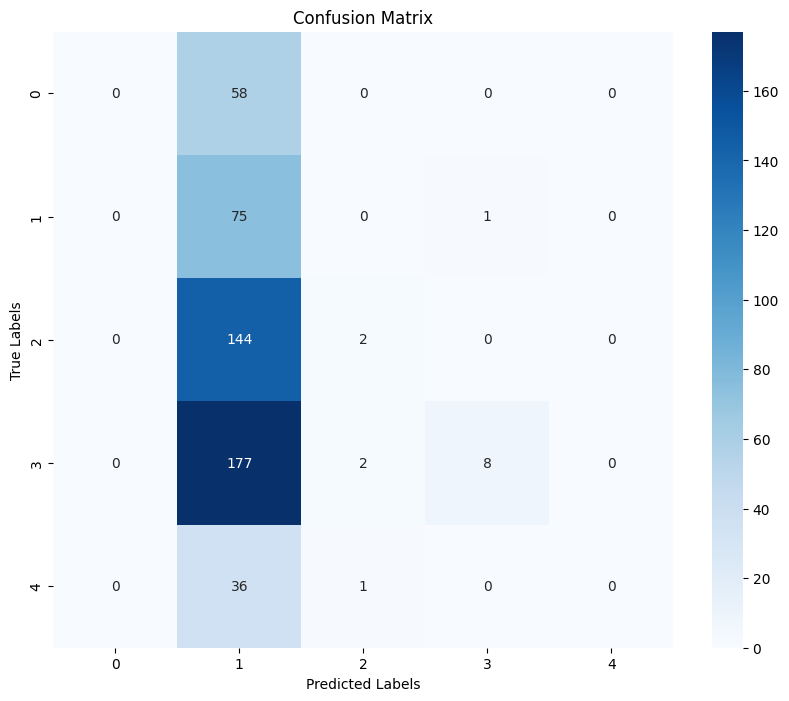

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val_true_classes, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique, yticklabels=unique)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [96]:
# Step 8: Create Submission File
submission = pd.DataFrame({
    'ID': test_ids,
    'Predictions': predicted_classes
})

NameError: name 'test_ids' is not defined

In [97]:
# Save submission variable as a .csv file in the current working directory
submission.to_csv('submission5.csv', index=False)
print("Submission file created successfully.")

NameError: name 'submission' is not defined

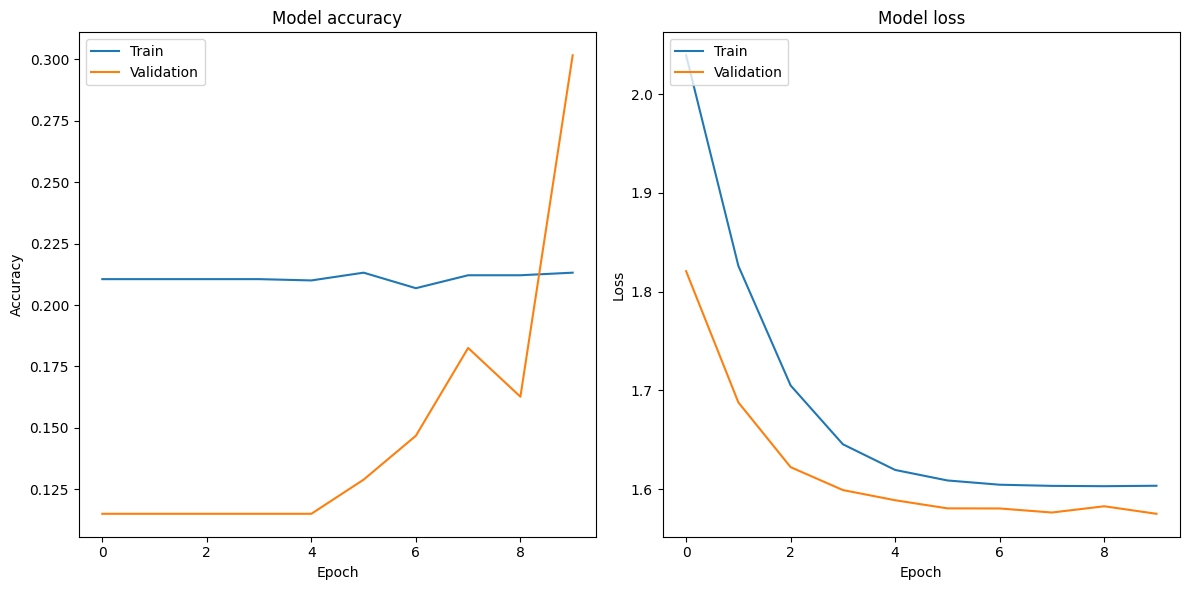

In [98]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_resampled.history['accuracy'])
plt.plot(history_resampled.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_resampled.history['loss'])
plt.plot(history_resampled.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

plt.show()